# Challenge #2 - Make a New Forecasting Function

<small>Python for Data Science Automation Course (DS4B 101-P)</small><br>
<small>Business Science</small> 

## Challenge Summary

This is a short challenge to extend your ability to review python `sktime` documentation. You will go through a series of questions related to:

1. Creating a New Forecasting Function using Exponential Smoothing

2. Forecasting Revenue By Customers

### Data Science Request

Your Data Science Manager has requested you to implement a second forecasting algorithm called "Exponential Smoothing" or ETS. Your goal is to leverage your knowledge of the existing ARIMA function you've created and make a new function that swaps ARIMA for ETS.  

### Objectives

1. Use your `sktime` documentation sloothing skills to make a a new ETS forecasting function.

2. Apply the function to forecast revenue by customers.

## Getting Started

### Check Working Directory

To read in the data, make sure your current working directory is set to the project directory. Two useful [jupyter magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html) are:

1. `%pwd`: [Print working directory](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd) (you can detect your current directory)
2. `%cd`: You can [change directory](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd) to your working directory using relative paths or full paths. 


In [1]:
%pwd

'C:\\Users\\mdanc\\OneDrive\\Desktop\\DS4B_101P_Course\\Challenge 2'

In [4]:
%cd C:\\Users\\mdanc\\OneDrive\\Desktop\\DS4B_101P_Course

C:\Users\mdanc\OneDrive\Desktop\DS4B_101P_Course


### Python Package Imports

In [5]:
# imports
import pandas as pd
import numpy as np

from my_pandas_extensions.database import collect_data
from my_pandas_extensions.timeseries import summarize_by_time

### Import Data

Use `collect_data()` to fetch your data from the SQLite Database. Save your data as `df`.

In [6]:
# Use collect_data() to connect to the SQL database and fetch your data

df = collect_data()
df.head()

order_id  order_line order_date  quantity  price  total_price  \
0         1           1 2011-01-07         1   6070         6070   
1         1           2 2011-01-07         1   5970         5970   
2         2           1 2011-01-10         1   2770         2770   
3         2           2 2011-01-10         1   5970         5970   
4         3           1 2011-01-10         1  10660        10660   

                      model category_1     category_2 frame_material  \
0           Jekyll Carbon 2   Mountain  Over Mountain         Carbon   
1          Trigger Carbon 2   Mountain  Over Mountain         Carbon   
2       Beast of the East 1   Mountain          Trail       Aluminum   
3          Trigger Carbon 2   Mountain  Over Mountain         Carbon   
4  Supersix Evo Hi-Mod Team       Road     Elite Road         Carbon   

               bikeshop_name         city state  
0   Ithaca Mountain Climbers       Ithaca    NY  
1   Ithaca Mountain Climbers       Ithaca    NY  
2          Kansas City 29ers  Kansas City    KS  
3          Kansas City 29ers  Kansas City    KS  
4  Louisville Race Equipment   Louisville    KY

We'll make use of our `arima_forecast()` function as a starting point for modification. 

In [7]:
from sktime.forecasting.arima import AutoARIMA
from tqdm import tqdm

def arima_forecast(
    data, h, sp, alpha = 0.05, 
    suppress_warnings = True, 
    *args, **kwargs
    ):

    # Checks

    # Handle Inputs ----
    df = data

    # FOR LOOP ----

    model_results_dict = {}
    for col in tqdm(df.columns, mininterval=0):

        # Series Extraction
        y = df[col]

        # Modeling
        forecaster = AutoARIMA(
            sp = sp, 
            suppress_warnings = suppress_warnings,
            *args, 
            **kwargs
        )

        forecaster.fit(y)

        # Predictions & Conf Intervals

        predictions, conf_int_df = forecaster.predict(
            fh              = np.arange(1, h+1),
            return_pred_int = True,
            alpha           = alpha 
        )

        # Combine into data frame
        ret = pd.concat([y, predictions, conf_int_df], axis=1)
        ret.columns = ["value", "prediction", "ci_lo", "ci_hi"]

        # Update Dictionary
        model_results_dict[col] = ret

    # Stack Each Dict Element on Top of Each Other
    model_results_df = pd.concat(
        model_results_dict, 
        axis=0
    )

    # Handle Names
    nms = [*df.columns.names, *df.index.names]
    model_results_df.index.names = nms

    # Reset Index
    ret = model_results_df.reset_index()

    # Drop columns containing "level"
    cols_to_keep = ~ret.columns.str.startswith("level_")

    ret = ret.iloc[:, cols_to_keep]

    return ret

## Challenge

Perform the following tasks. 

### Task 1: Make an ETS Forecasting Function

1. Copy the `arima_forecast`
2. Import the [AutoETS Function](https://www.sktime.org/en/v0.5.3/api_reference/modules/auto_generated/sktime.forecasting.ets.AutoETS.html?highlight=autoets) from **version 0.5.3** of `sktime`
3. Rename the `arima_forecast()` function to `ets_forecast()`
4. Change the internals of the function to swap out `AutoARIMA()` for `AutoETS()`

In [24]:
# Code
from sktime.forecasting.ets import AutoETS
from tqdm import tqdm

def ets_forecast(
    data, h, sp, 
#     alpha = 0.05, 
    suppress_warnings = True, 
    *args, **kwargs
    ):

    # Checks

    # Handle Inputs ----
    df = data

    # FOR LOOP ----

    model_results_dict = {}
    for col in tqdm(df.columns, mininterval=0):

        # Series Extraction
        y = df[col].astype("float64") + 1

        
        # Modeling
        forecaster = AutoETS(
            sp = sp, 
            suppress_warnings = suppress_warnings, 
            *args, 
            **kwargs
        )

        forecaster.fit(y)

        # Predictions & Conf Intervals
        
        # ---- CHANGE 1 ----
#         predictions, conf_int_df = forecaster.predict(
#             fh              = np.arange(1, h+1),
#             return_pred_int = True,
#             alpha           = alpha 
#         )

        predictions = forecaster.predict(
            fh              = np.arange(1, h+1)
        )


        # Combine into data frame
        
        # --- CHANGE 2 ----
#         ret = pd.concat([y, predictions, conf_int_df], axis=1)
#         ret.columns = ["value", "prediction", "ci_lo", "ci_hi"]
        
        ret = pd.concat([y, predictions], axis=1)
        ret.columns = ["value", "prediction"]

        # Update Dictionary
        model_results_dict[col] = ret

    # Stack Each Dict Element on Top of Each Other
    model_results_df = pd.concat(
        model_results_dict, 
        axis=0
    )

    # Handle Names
    nms = [*df.columns.names, *df.index.names]
    model_results_df.index.names = nms

    # Reset Index
    ret = model_results_df.reset_index()

    # Drop columns containing "level"
    cols_to_keep = ~ret.columns.str.startswith("level_")

    ret = ret.iloc[:, cols_to_keep]

    return ret

### Task 2: Test the `ets_forecast()` function

In [19]:
bike_sales_cat2_m_df = df \
    .summarize_by_time(
        date_column = 'order_date',
        value_column = 'total_price',
        groups = ['category_2'],
        rule = 'M',
        kind = 'period'
    )

bike_sales_cat2_m_df.head()

total_price                                                \
category_2 Cross Country Race Cyclocross Elite Road Endurance Road Fat Bike   
order_date                                                                    
2011-01              143660.0     7910.0   144765.0        83200.0      0.0   
2011-02              324400.0    24010.0   291410.0       138000.0  37820.0   
2011-03              142000.0    21490.0   148340.0        87790.0  13850.0   
2011-04              498580.0    51870.0   371385.0       216360.0  89500.0   
2011-05              220310.0    47390.0   212520.0       114320.0   2130.0   

                                                        
category_2 Over Mountain    Sport     Trail Triathalon  
order_date                                              
2011-01          35930.0   7750.0   34150.0    25650.0  
2011-02         114990.0  28815.0  154530.0    48100.0  
2011-03         139240.0  17565.0   46200.0    43500.0  
2011-04         171160.0  52525.0  264210.0   111550.0  
2011-05          73650.0  42120.0  112230.0    19500.0

1. Start with `bike_sales_cat2_m_df`
2. Use the `ets_forecast()` function to forecast with the following parameters:
```
ets_forecast(
    data     = bike_sales_cat2_m_df,
    h        = 12, 
    sp       = 12, 
    seasonal = "add", # For additive seasonality 
    trend    = "add"  # For additive trend
)
```
3. Troubleshoot the Prediction "Not Yet Implemented Error" 
    - Go back to your function and make changes to remove the confidence interval
    - Remove the `alpha` argument from the function
4. Use `.groupby()` to group by `category_2`.
5. Use `.plot()` to plot with `x = 'order_date'.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.42it/s]


category_2
Cross Country Race    AxesSubplot(0.125,0.125;0.775x0.755)
Cyclocross            AxesSubplot(0.125,0.125;0.775x0.755)
Elite Road            AxesSubplot(0.125,0.125;0.775x0.755)
Endurance Road        AxesSubplot(0.125,0.125;0.775x0.755)
Fat Bike              AxesSubplot(0.125,0.125;0.775x0.755)
Over Mountain         AxesSubplot(0.125,0.125;0.775x0.755)
Sport                 AxesSubplot(0.125,0.125;0.775x0.755)
Trail                 AxesSubplot(0.125,0.125;0.775x0.755)
Triathalon            AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

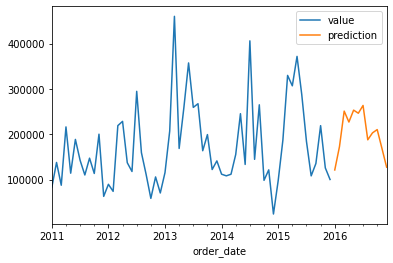

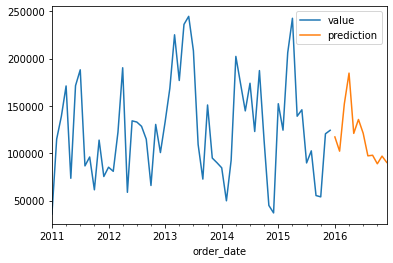

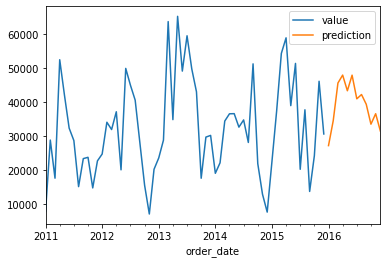

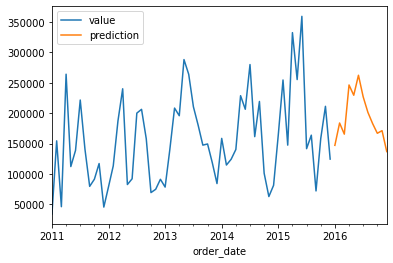

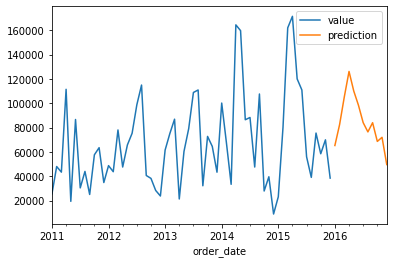

In [25]:
# Code

ets_forecast(
    data = bike_sales_cat2_m_df,
    h    = 12, 
    sp   = 12, 
    seasonal = "add", 
    trend    = "add"
) \
    .groupby('category_2') \
    .plot(x = 'order_date')

## Nice Work

This challenge tested your ability to research documentatoin and debug code. If you nailed it, you're doing awesome. If you didn't, guess what - You're still awesome too! Keep in mind you're learning, it takes time, and these challenges are meant to be *challenging*. 